In [2]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'pc_grc_pattern_correlation_210101'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData

# ap = argparse.ArgumentParser()
# ap.add_argument("--min_length", type=int, default=20)
# ap.add_argument("--max_dist", type=int, default=100)
# config = ap.parse_args()

max_dist = 150

from weight_database import WeightDatabase
weightdb = WeightDatabase()

weightdb.load_syn_db('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/grc_axons/gen_201224_setup01_syndb_threshold_10_coalesced_filtered_10.gz')
weightdb.load_touch_db(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/purkinje/grc_pc_touches_201224.gz',
    max_dist=max_dist
    )

postsyns = weightdb.get_postsyn_ids()

In [3]:
min_length = 30

paired_correlation = defaultdict(lambda: defaultdict(float))
data_grc = []

def calc_pattern_correlation(weightdb, type='Data'):
    mpd = MyPlotData()
    processed = set()
    n = 0
    for pc0 in postsyns:
        for pc1 in postsyns:
            paired_correlation[pc0][pc1] = None
            paired_correlation[pc1][pc0] = None
            if pc0 == pc1:
                continue
            if (pc0, pc1) in processed:
                continue
            processed.add((pc0, pc1))
            processed.add((pc1, pc0))
            if len(weightdb.get_shared_presyns(pc0, pc1)) < min_length:
                continue

            score = weightdb.calc_pattern_correlation(pc0, pc1, spearman=True)
            if math.isnan(score):
                score = 0
            paired_correlation[pc0][pc1] = score
            paired_correlation[pc1][pc0] = score
            data_grc.append(score)
            mpd.add_data_point(
                score=score,
                type=type,
                )
            n += 1

    print(f'n={n} pairs')
    return mpd

mpd_data = calc_pattern_correlation(weightdb)

weightdb_random = weightdb.randomize_connectivity(type='postsyn')
mpd_random = calc_pattern_correlation(weightdb_random, type='Random')


n=153 pairs
n=153 pairs


In [6]:
import compress_pickle
data_pfs, data_random = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/pfs_pc_analysis/pc_pfs_pattern_correlation_210107_spearman_max_dist_150_min_length_30_n5_data.gz')


import scipy
fout_name = f'{script_n}_max_dist_{max_dist}_min_length_{min_length}'
with open(f'{script_n}_results', 'w') as fout:
    for foutt in [fout, sys.stdout]:
        print('Comparing grc to pfs', file=foutt)
        print(scipy.stats.ttest_ind(data_grc, data_pfs), file=foutt)
        print(scipy.stats.ranksums(data_grc, data_pfs), file=foutt)
        print(scipy.stats.mannwhitneyu(data_grc, data_pfs, alternative='greater'), file=foutt)
        print(scipy.stats.ks_2samp(data_grc, data_pfs), file=foutt)
        print('Comparing grc to random', file=foutt)
        print(scipy.stats.ttest_ind(data_grc, data_random), file=foutt)
        print(scipy.stats.ranksums(data_grc, data_random), file=foutt)
        print(scipy.stats.mannwhitneyu(data_grc, data_random, alternative='greater'), file=foutt)
        print(scipy.stats.ks_2samp(data_grc, data_random), file=foutt)



Comparing grc to pfs
Ttest_indResult(statistic=-0.8806851107802506, pvalue=0.37871008451098254)
RanksumsResult(statistic=-0.8725133315972947, pvalue=0.3829283984883166)
MannwhitneyuResult(statistic=95975.0, pvalue=0.8085700273590612)
KstestResult(statistic=0.09893413775766717, pvalue=0.03126656758312918)
Comparing grc to random
Ttest_indResult(statistic=-0.8371138745535459, pvalue=0.40258484758246493)
RanksumsResult(statistic=-0.9543171803922925, pvalue=0.33992311411884835)
MannwhitneyuResult(statistic=480865.0, pvalue=0.8300458112569374)
KstestResult(statistic=0.10906787330316742, pvalue=0.0023571473478962712)


Height: 4, Aspect: 0.75


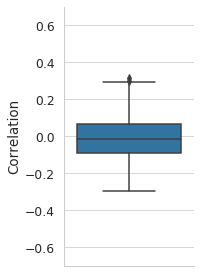

In [7]:
mpd_all = MyPlotData()
mpd_all.append(mpd_data)
# mpd_all.append(mpd_random)

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
#     x="type",
    y="score",
    ylim=[-.7, .7],
    context='paper',
    kind='box',
    height=4,
    width=3,
    y_axis_label='Correlation',
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )


Height: 4, Aspect: 0.875


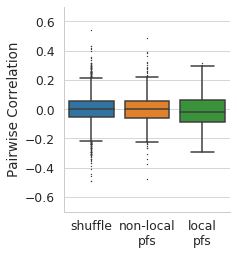

In [15]:
mpd_all = MyPlotData()

mpd_pfs = MyPlotData()
for val in data_pfs:
    mpd_pfs.add_data_point(
        score=val,
        type='non-local\npfs',
        )

mpd_pfs_random = MyPlotData()
for val in data_random:
    mpd_pfs_random.add_data_point(
        score=val,
        type='Shuffle',
        )


mpd_all.append(mpd_pfs_random)
mpd_all.append(mpd_pfs)
mpd_all.append(mpd_data)
# mpd_all.append(mpd_random)

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    x="type",
    xticklabels=['shuffle', 'non-local\npfs', 'local\npfs'],
    y="score",
    ylim=[-.7, .7],
    context='paper',
    kind='box',
    fliersize=.5,
    height=4,
    width=3.5,
    y_axis_label='Pairwise Correlation',
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_combined.svg',
    show=True,
    )


Height: 4, Aspect: 1.33


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


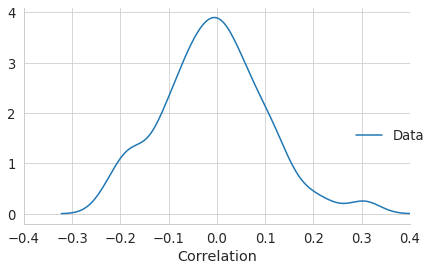

In [4]:


importlib.reload(my_plot); my_plot.my_displot(
    mpd_all,
    # x="num_syns_per_connection",
    x="score",
    hue="type",
    # hue_order=['All', 'Per PC', 'Per pf'],
    # hue_order=['All', 'Per PC'],
#     ylim=[.30, .70],
    xlim=[-.4, .4],
    context='paper',
    kind='kde',
    # add_swarm=True,
    # font_scale=1.5,
    height=4,
    bw_adjust=.75,
#     binwidth=.02,
    # width=2.5,
    # y_axis_label='Similarity (%)',
    x_axis_label='Correlation',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_kde.svg',
    show=True,
    )

In [5]:

for min_length in [10, 20, 30, 40, 50]:

    paired_correlation = defaultdict(lambda: defaultdict(float))

    def calc_pattern_correlation(weightdb, type='Data'):
        mpd = MyPlotData()
        processed = set()
        n = 0
        for pc0 in postsyns:
            for pc1 in postsyns:
                if (pc0, pc1) in processed:
                    continue
                paired_correlation[pc0][pc1] = 0
                paired_correlation[pc1][pc0] = 0
                if pc0 == pc1:
                    paired_correlation[pc0][pc1] = 1
                    continue
                processed.add((pc0, pc1))
                processed.add((pc1, pc0))
                if len(weightdb.get_shared_presyns(pc0, pc1)) < min_length:
                    continue

                score = weightdb.calc_pattern_correlation(pc0, pc1)
                paired_correlation[pc0][pc1] = score
                paired_correlation[pc1][pc0] = score
                mpd.add_data_point(
                    score=score,
                    type=type,
                    )
                n += 1

        print(f'n={n} pairs')
        return mpd

    mpd_data = calc_pattern_correlation(weightdb)

    import compress_pickle
    compress_pickle.dump(
        dict(paired_correlation),
        f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_paired_score.gz',)

/home/tmn7/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


n=273 pairs
n=181 pairs
n=153 pairs
n=122 pairs
n=99 pairs


In [6]:

for min_length in [10, 20, 30, 40, 50]:

    paired_correlation = defaultdict(lambda: defaultdict(float))

    def calc_pattern_correlation(weightdb, type='Data'):
        mpd = MyPlotData()
        processed = set()
        n = 0
        for pc0 in postsyns:
            for pc1 in postsyns:
                if (pc0, pc1) in processed:
                    continue
                paired_correlation[pc0][pc1] = None
                paired_correlation[pc1][pc0] = None
                if pc0 == pc1:
                    paired_correlation[pc0][pc1] = 1
                    continue
                processed.add((pc0, pc1))
                processed.add((pc1, pc0))
                if len(weightdb.get_shared_presyns(pc0, pc1)) < min_length:
                    continue

                score = weightdb.calc_pattern_correlation(pc0, pc1)
                paired_correlation[pc0][pc1] = score+.5
                paired_correlation[pc1][pc0] = score+.5
                mpd.add_data_point(
                    score=score,
                    type=type,
                    )
                n += 1

        print(f'n={n} pairs')
        return mpd

    mpd_data = calc_pattern_correlation(weightdb)

    import compress_pickle
    compress_pickle.dump(
        dict(paired_correlation),
        f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_paired_score.gz',)

n=273 pairs
n=181 pairs
n=153 pairs
n=122 pairs
n=99 pairs
